#Bike Shop Analytics: A SQL-Driven Analysis

This project focuses on leveraging SQL to analyze key aspects of a bike shop's operations, including sales performance, customer behavior, and product trends. By exploring this dataset, the goal is to derive actionable insights that can support business decisions, such as identifying top-performing sales representatives, understanding customer preferences, and optimizing inventory management.

#Objectives:
- **Sales Performance:** Analyze sales trends across regions, products, and representatives to uncover top performers and opportunities for improvement.
- **Customer Insights:** Identify frequent customers and their purchasing behaviors to enhance customer retention strategies.
- **Product Analysis:** Evaluate the popularity and profitability of bike models to guide future inventory and marketing decisions.




In [2]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns


connection = sqlite3.connect('bike_store.db')

brands = pd.read_csv('/content/drive/MyDrive/archive (12).zip (Unzipped Files)/brands.csv')
categories = pd.read_csv('/content/drive/MyDrive/archive (12).zip (Unzipped Files)/categories.csv')
customers = pd.read_csv('/content/drive/MyDrive/archive (12).zip (Unzipped Files)/customers.csv')
order_items = pd.read_csv('/content/drive/MyDrive/archive (12).zip (Unzipped Files)/order_items.csv')
orders = pd.read_csv('/content/drive/MyDrive/archive (12).zip (Unzipped Files)/orders.csv')
products = pd.read_csv('/content/drive/MyDrive/archive (12).zip (Unzipped Files)/products.csv')
staffs = pd.read_csv('/content/drive/MyDrive/archive (12).zip (Unzipped Files)/staffs.csv')
stocks = pd.read_csv('/content/drive/MyDrive/archive (12).zip (Unzipped Files)/stocks.csv')
stores = pd.read_csv('/content/drive/MyDrive/archive (12).zip (Unzipped Files)/stores.csv')

brands.to_sql('brands', connection, if_exists='replace', index=False)
categories.to_sql('categories', connection, if_exists='replace', index=False)
customers.to_sql('customers', connection, if_exists='replace', index=False)
order_items.to_sql('order_items', connection, if_exists='replace', index=False)
orders.to_sql('orders', connection, if_exists='replace', index=False)
products.to_sql('products', connection, if_exists='replace', index=False)
staffs.to_sql('staffs', connection, if_exists='replace', index=False)
stocks.to_sql('stocks', connection, if_exists='replace', index=False)
stores.to_sql('stores', connection, if_exists='replace', index=False)



3

# Objective: Identify the best-performing sales representatives by state to recognize and incentivize high performance.

 Findings:
 - New York has the highest sales revenue among all states.
 - The top-performing representatives are:
   - Boyer (NY): $2,624,120.65

   - Serrano (CA): $853,287.36

   - Vargas (TX): $463,918.30

 Action Plan:
    - Reward top sales representatives with bonuses or recognition programs.
    - Use their strategies as benchmarks for other teams.

Recommended Visual:
   - A horizontal bar chart comparing total sales by representatives across states.

In [3]:
best_sales_rep_query_by_state = '''
  WITH T1 AS(SELECT s.staff_id staff_id, s.last_name staff_last_name, sto.state store_state, ROUND(SUM((oi.list_price - (oi.list_price*oi.discount)) * oi.quantity),2) total_sales_usd
              FROM staffs s
              JOIN orders o ON o.staff_id = s.staff_id
              JOIN stores st ON st.store_id = o.store_id
              JOIN order_items oi ON oi.order_id = o.order_id
              JOIN stores sto ON sto.store_id = st.store_id
              GROUP BY 1,2,3),

        T2 AS (
              SELECT store_state, MAX(total_sales_usd) max_sales_usd
              FROM T1
              GROUP BY 1
              ORDER BY 2 DESC
  )


  SELECT t1.staff_id, t1.staff_last_name, t1.store_state, t1.total_sales_usd
  FROM T1
  JOIN T2 ON t1.total_sales_usd = t2.max_sales_usd
  ORDER BY 4 DESC;


'''

In [4]:
best_sales_rep_per_state = pd.read_sql_query(best_sales_rep_query_by_state, connection)
best_sales_rep_per_state

,staff_id,staff_last_name,store_state,total_sales_usd
0,6,Boyer,NY,2624120.65
1,3,Serrano,CA,853287.36
2,8,Vargas,TX,463918.30


<Axes: ylabel='staff_last_name'>

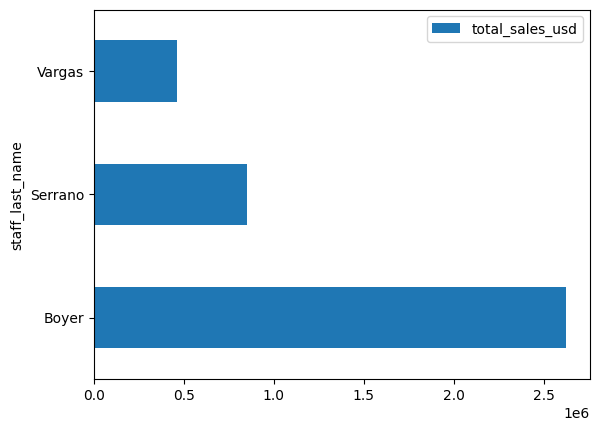

In [5]:
best_sales_rep_per_state.plot.barh(x='staff_last_name',y='total_sales_usd')

# Objective: Retain high-spending customers.

# Findings:
 - Top customers:
   1. Hopkins: $34.8K

   2. Newman: $33.6K

   3. Gamble: $32.8K



# Some top spenders haven’t purchased recently.

   Action Plan:
  - Target inactive top customers with promotions.
  - Develop loyalty programs.

# Visual: Bar chart of customer spending.

In [6]:
customers_that_spent_most = '''SELECT c.customer_id customer_id,first_name|| ' ' || last_name first_and_last_name,ROUND(SUM((oi.list_price - (oi.list_price*oi.discount)) * oi.quantity),2) customer_total_spend, count(*) total_amount_of_orders
      FROM customers c
      JOIN orders o ON o.customer_id = c.customer_id
      JOIN order_items oi ON oi.order_id = o.order_id
      GROUP BY 1
      ORDER BY 3 DESC
      LIMIT 10;
      '''

customer_spend = pd.read_sql_query(customers_that_spent_most, connection)
customer_spend

,customer_id,first_and_last_name,customer_total_spend,total_amount_of_orders
0,94,Sharyn Hopkins,34807.94,10
1,10,Pamelia Newman,33634.26,11
2,75,Abby Gamble,32803.01,7
3,6,Lyndsey Bean,32675.07,11
4,16,Emmitt Sanchez,31925.89,12
5,73,Melanie Hayes,31913.69,7
6,1,Debra Burks,27888.18,11
7,61,Elinore Aguilar,25636.45,10
8,93,Corrina Sawyer,25612.70,8
9,122,Shena Carter,24890.62,4


<Axes: ylabel='first_and_last_name'>

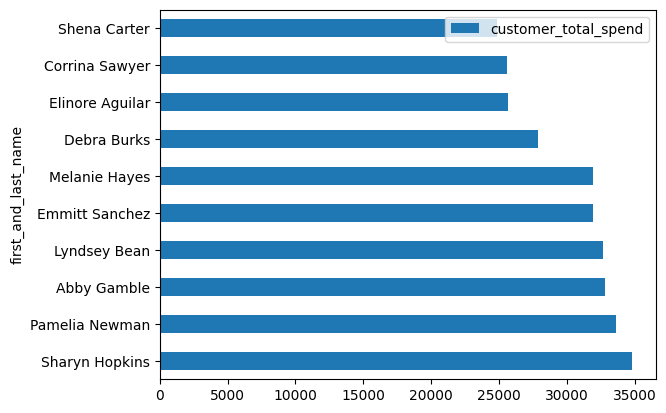

In [7]:
customer_spend.plot.barh(x='first_and_last_name',y='customer_total_spend')

In [8]:
query = '''SELECT c.customer_id, c.last_name, MAX(o.order_date) last_order
      FROM customers c
      JOIN orders o ON c.customer_id = o.customer_id
      GROUP BY 1,2
      LIMIT 1'''

pd.read_sql_query(query, connection)

,customer_id,last_name,last_order
0,1,Burks,2018-11-18


In [9]:
frequent_customers_last_orders = '''
      WITH T1 AS (SELECT c.customer_id customer_id, c.last_name customer_last_name,ROUND(SUM((oi.list_price - (oi.list_price*oi.discount)) * oi.quantity),2) customer_total_spend
      FROM customers c
      JOIN orders o ON o.customer_id = c.customer_id
      JOIN order_items oi ON oi.order_id = o.order_id
      GROUP BY 1
      ORDER BY 3 DESC
      LIMIT 5)

      SELECT c.customer_id, c.last_name, MAX(o.order_date) last_order
      FROM customers c
      JOIN orders o ON c.customer_id = o.customer_id
      WHERE c.customer_id IN (SELECT customer_id FROM T1)
      GROUP BY 1,2
      ORDER BY o.order_date




'''

customer_frequency_last_order = pd.read_sql_query(frequent_customers_last_orders , connection)
customer_frequency_last_order.head()

,customer_id,last_name,last_order
0,94,Hopkins,2018-04-01
1,75,Gamble,2018-04-08
2,16,Sanchez,2018-04-09
3,10,Newman,2018-08-23
4,6,Bean,2018-09-06


In [10]:
highest_sales_state_total_orders = '''
    WITH T1 AS (SELECT s.state state, ROUND(SUM((oi.list_price - (oi.list_price*oi.discount)) * oi.quantity),2) total_sales_amt_usd
    FROM stores s
    JOIN orders o ON o.store_id = s.store_id
    JOIN order_items oi ON oi.order_id = o.order_id
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 1)

    SELECT s.state state, COUNT(*) total_order_from_state_with_highest_sales
    FROM stores s
    JOIN orders o ON s.store_id = o.store_id
    WHERE s.state = (SELECT state FROM T1)
'''

# Objective: Identify regions for expansion.

 Findings:
 - NY leads in sales and orders.
 - Top cities: Mount Vernon, Baldwin.

# Action Plan:
 - Open a new store in New Rochelle, NY.
 - Allocate resources to top-performing regions.

# Visual: Geographic heatmap of sales.

In [11]:
pd.read_sql_query(highest_sales_state_total_orders, connection)

,state,total_order_from_state_with_highest_sales
0,NY,1093


In [12]:
customer_city_highest_sales_query = '''
      WITH T1 AS(SELECT c.state customer_state, c.city customer_city, ROUND(SUM((oi.list_price - (oi.list_price*oi.discount)) * oi.quantity),2) total_amt_usd
      FROM customers c
      JOIN orders o ON c.customer_id = o.customer_id
      JOIN order_items oi ON oi.order_id = o.order_id
      GROUP BY 1,2),

      T2 AS (SELECT customer_state, MAX(total_amt_usd) total_amt_usd
      FROM T1
      GROUP BY 1)

      SELECT T1.customer_state, T1.customer_city, T1.total_amt_usd
      FROM T1
      JOIN T2 ON T1.total_amt_usd = T2.total_amt_usd
      ORDER BY 3 DESC

'''

customer_city_highest_sales = pd.read_sql_query(customer_city_highest_sales_query,connection)

customer_city_highest_sales

,customer_state,customer_city,total_amt_usd
0,NY,Mount Vernon,105563.33
1,TX,San Angelo,98429.26
2,CA,Canyon Country,86520.53


In [13]:
busiest_store_query = '''
      WITH T1 AS(SELECT s.state store_state, s.city store_city, ROUND(SUM((oi.list_price - (oi.list_price*oi.discount)) * oi.quantity),2) total_amt_usd
      FROM stores s
      JOIN orders o ON s.store_id = o.store_id
      JOIN order_items oi ON oi.order_id = o.order_id
      GROUP BY 1,2),

      T2 AS (SELECT store_state, MAX(total_amt_usd) total_amt_usd
      FROM T1
      GROUP BY 1)

      SELECT T1.store_state, T1.store_city, T1.total_amt_usd
      FROM T1
      JOIN T2 ON T1.total_amt_usd = T2.total_amt_usd
      ORDER BY 3 DESC

'''

busiest_store = pd.read_sql_query(busiest_store_query,connection)

busiest_store

,store_state,store_city,total_amt_usd
0,NY,Baldwin,5215751.28
1,CA,Santa Cruz,1605823.04
2,TX,Rowlett,867542.24


# Objective: Focus on profitable products.

# Findings:
- Highest revenue categories:
    - Mountain Bikes
    - Electric Bikes
    
# Top product:
  - Trek Slash 8 ($555K).

# Action Plan:
 - Prioritize inventory for high-performing products.
 - Bundle accessories with top sellers.

# Visuals:
 - Histogram: Revenue by category.
 - Pivot table: Revenue tiers by category.

In [14]:
product_query = '''
    SELECT p.product_name,
           c.category_name,
           ROUND(SUM((o.list_price - (o.list_price*o.discount)) * o.quantity),2) total_amt_usd,
           SUM(o.quantity) total_quantity_sold,
           RANK() OVER (ORDER BY SUM((o.list_price - (o.list_price*o.discount)) * o.quantity) DESC) AS sales_rank,
           CASE
               WHEN SUM((o.list_price - (o.list_price*o.discount)) * o.quantity) >= 1000 THEN 'High Revenue'
               WHEN SUM((o.list_price - (o.list_price*o.discount)) * o.quantity) >= 500 THEN 'Medium Revenue'
               ELSE 'Low Revenue'
           END AS revenue_category
    FROM  products p
    JOIN order_items o ON p.product_id = o.product_id
    JOIN categories c ON p.category_id = c.category_id
    GROUP BY 1,2
    ORDER BY 3 DESC
'''

product_query = pd.read_sql_query(product_query,connection)

product_query.head(20)

,product_name,category_name,total_amt_usd,total_quantity_sold,sales_rank,revenue_category
0,Trek Slash 8 27.5 - 2016,Mountain Bikes,555558.61,154,1,High Revenue
1,Trek Conduit+ - 2016,Electric Bikes,389248.70,145,2,High Revenue
2,Trek Fuel EX 8 29 - 2016,Mountain Bikes,368472.73,143,3,High Revenue
3,Surly Straggler 650b - 2016,Cyclocross Bicycles,226765.55,151,4,High Revenue
4,Trek Domane SLR 6 Disc - 2017,Road Bikes,211584.62,43,5,High Revenue
5,Surly Straggler - 2016,Cyclocross Bicycles,203507.62,147,6,High Revenue
6,Trek Remedy 29 Carbon Frameset - 2016,Mountain Bikes,203380.87,125,7,High Revenue
7,Trek Powerfly 8 FS Plus - 2017,Electric Bikes,188249.62,41,8,High Revenue
8,Trek Madone 9.2 - 2017,Road Bikes,175899.65,39,9,High Revenue
9,Trek Silque SLR 8 Women's - 2017,Road Bikes,174524.73,29,10,High Revenue


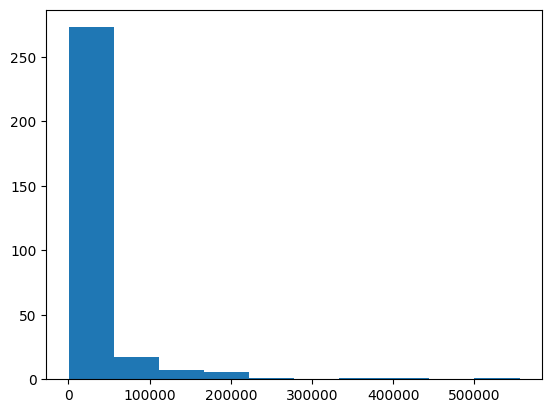

In [15]:
plt.hist(product_query["total_amt_usd"])
plt.show()

In [16]:
pivot_table = pd.pivot_table(data=product_query,values='total_amt_usd',index='category_name',columns='revenue_category',aggfunc='sum')
pivot_table

revenue_category,High Revenue,Low Revenue,Medium Revenue
category_name,,,
Children Bicycles,283641.02,4101.76,4446.38
Comfort Bicycles,392060.11,447.99,1511.98
Cruisers Bicycles,990246.31,546.98,4239.30
Cyclocross Bicycles,711011.83,NaN,NaN
Electric Bikes,916684.78,NaN,NaN
Mountain Bikes,2715079.55,NaN,NaN
Road Bikes,1664385.98,NaN,712.49


#### Analyzing sales data reveals a strong correlation between the availability of high-demand accessories (like helmets, lights, and racks) and increased sales of higher-priced bicycles. This suggests that customers are more likely to make a significant purchase when they can easily and conveniently complete their cycling setup within the same shopping experience.

**How this insight can be used:**

- **Inventory Management:**
    - Prioritize stocking popular accessories: Ensure consistent availability of high-demand accessories to capitalize on the potential for increased bicycle sales.
    - Consider bundle deals: Offer attractive packages that include a bicycle and essential accessories to incentivize customers and streamline the purchasing process.

- **Customer Behavior:**
    - Improve in-store displays: Create dedicated sections for accessories and strategically place them near high-ticket bicycles to encourage impulse purchases and complete setups.
    - Provide expert advice: Train staff to recommend relevant accessories based on customer needs and the chosen bicycle, enhancing the overall customer experience.
    - Offer convenient add-on options: Provide clear and easy options for customers to add accessories to their online or in-store orders.

By leveraging this insight, the store can optimize inventory, enhance the customer experience, and ultimately drive higher sales and customer satisfaction.
